In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

In [2]:
filename = 'UrbanSound8K/UrbanSound8K/audio/fold1/7383-3-0-0.wav'

In [3]:
plt.figure(figsize=(12, 4))
data, sample_rate = librosa.load(filename)
print("Sample rate :", sample_rate)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(data, rate=sample_rate)

In [ ]:
# Do the same audio EDA as above but with sci-py.(1 major disadvantage here is the data collected from audio is not regularized)
from scipy.io import wavfile as wav
wav_sample_rate, wav_data = wav.read(filename)

In [ ]:
from scipy.io.wavfile import read
audio = read(filename)

In [ ]:
audio[1]

array([[   0,    0],
       [   0,    0],
       [   0,    0],
       ...,
       [-399, -115],
       [-388, -111],
       [-386, -105]], dtype=int16)

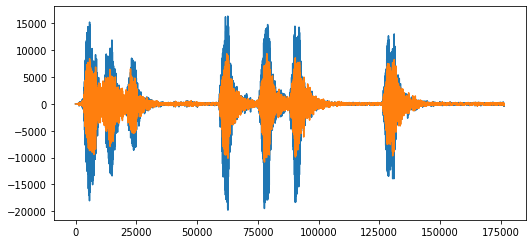

In [ ]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.plot(audio[1])

In [ ]:
import pandas as pd

metadata=pd.read_csv('UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [ ]:
### Check whether the dataset is imbalanced
metadata['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [ ]:
metadata.shape

(8732, 8)

**Now comes the preprocessing part**

Extract features using Mel-Frequency Cepstral Coefficients(MFCC)

In [ ]:
mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)

In [ ]:
mfcc

array([[-5.7041687e+02, -5.0580988e+02, -4.4661014e+02, ...,
        -4.8128598e+02, -4.7245877e+02, -4.6424646e+02],
       [ 3.2360138e+01,  9.3758621e+01,  1.4270895e+02, ...,
         1.0403226e+02,  1.1474959e+02,  1.1683490e+02],
       [ 2.6088993e+01,  3.4996731e+01,  4.0650402e+01, ...,
         1.1899885e+01,  1.7138016e+01,  1.3884659e+01],
       ...,
       [ 5.9291804e-01,  2.7261610e+00, -2.6107316e+00, ...,
        -2.7341051e+00, -3.7578499e+00, -5.8995886e+00],
       [-1.3069375e+00, -2.1206574e+00, -9.1924280e-01, ...,
        -1.2278645e+00, -3.3723919e+00, -4.1921663e+00],
       [-2.0638509e+00, -2.9027894e+00,  2.7276498e-01, ...,
        -1.3872089e+00, -3.3255339e+00, -8.4046578e-01]], dtype=float32)

Now create a feature extractor function

In [ ]:
def feature_extractor(file):
    librosa.load(file, res_type='kaiser_fast')
    mfcc_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
    mfcc_scaled_features =np.mean(mfcc_features.T,axis=0)

    return mfcc_scaled_features

In [ ]:
feature_extractor(filename)

array([-3.9728604e+02,  1.4199390e+02,  1.0424644e+01, -9.8004112e+00,
       -8.0245886e+00,  7.5154042e+00, -1.0164132e+01, -7.2393765e+00,
       -3.5004098e+00, -5.7000537e+00, -2.3489676e+00, -3.5407817e+00,
        5.2213383e+00,  9.1667747e+00,  9.7039452e+00,  1.2727837e+01,
        2.4204013e+00, -1.0693447e-01,  1.9542018e+00,  2.3954169e-01,
        1.1634955e-01, -2.0959182e+00, -4.3151698e+00, -7.4520910e-01,
        4.2331934e-01,  1.5813076e+00,  1.4602641e+00,  2.6433935e+00,
        4.3686604e+00,  1.9432870e+00,  2.9634244e-03,  4.8470337e-02,
        1.9078921e+00,  1.1821151e+00,  1.4464529e-01, -8.8062823e-01,
       -2.5595131e+00, -1.7090167e+00, -1.3550457e+00,  3.8210499e-01],
      dtype=float32)

In [ ]:
import os
import numpy as np
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
audio_dataset_path = 'UrbanSound8K/UrbanSound8K/audio/'
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=feature_extractor(file_name)
    extracted_features.append([data,final_class_labels])

0it [00:00, ?it/s]c:\Users\rohan\anaconda3\envs\tensorflow_env\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=40
  return f(*args, **kwargs)
147it [00:12, 11.93it/s]

Create a dataframe with the extracted features from above

In [ ]:
extracted_features_df = pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-397.28604, 141.9939, 10.424644, -9.800411, -...",dog_bark
1,"[450.72662, -21.561567, 12.0586605, -0.4794998...",children_playing
2,"[481.85965, -1.5298109, 0.6514032, -1.6475505,...",children_playing
3,"[490.1246, -0.18750022, 0.019547466, -0.025050...",children_playing
4,"[491.94803, -0.03681645, -0.012096148, -0.0235...",children_playing


In [ ]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [ ]:
X.shape, y.shape

((8732, 40), (8732,))

Time to change categorical variables of y into numerical variables using get_dummies

In [ ]:
y=np.array(pd.get_dummies(y))

Now to perform train test split on our audio data

In [ ]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6985, 40), (1747, 40), (6985, 10), (1747, 10))

In [ ]:
y_train.reshape(1,-1).shape

(1, 69850)

In [ ]:
y.shape

(8732, 10)

Model building

In [ ]:
# Now since all the preprocessing is done its time to create out model for the audio processing data
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
# Lets take a look at the number of classes we have
num_classes = y.shape[1]

In [ ]:
X_train.shape[1]

40

Model 1

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               4100      
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model 2

In [ ]:
model2 = Sequential()
model2.add(Dense(100, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(Dropout(0.5))
model2.add(Dense(200, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(100, activation='relu'))
mode2.add(Dropout(0.5))

model2.add(Dense(num_classes, activation='softmax'))
model2.summary()

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


NameError: name 'X_train' is not defined

Time for model1 training

In [ ]:
## Training my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
219/219 [==============================] - 0s 1ms/step - loss: 2.2559 - accuracy: 0.1144 - val_loss: 2.2698 - val_accuracy: 0.1048

Epoch 00001: val_loss improved from inf to 2.26980, saving model to saved_models\audio_classification.hdf5
Epoch 2/100
219/219 [==============================] - 0s 1ms/step - loss: 2.2566 - accuracy: 0.1141 - val_loss: 2.2698 - val_accuracy: 0.1048

Epoch 00002: val_loss improved from 2.26980 to 2.26976, saving model to saved_models\audio_classification.hdf5
Epoch 3/100
219/219 [==============================] - 0s 1ms/step - loss: 2.2561 - accuracy: 0.1101 - val_loss: 2.2699 - val_accuracy: 0.1048

Epoch 00003: val_loss did not improve from 2.26976
Epoch 4/100
219/219 [==============================] - 0s 1ms/step - loss: 2.2559 - accuracy: 0.1160 - val_loss: 2.2699 - val_accuracy: 0.1048

Epoch 00004: val_loss did not improve from 2.26976
Epoch 5/100
219/219 [==============================] - 0s 1ms/step - loss: 2.2562 - accuracy: 0.1140 - v

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.10417859256267548


Time for model2 training

In [ ]:
## Training my model2
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 64

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', verbose=1, save_best_only=True)
start = datetime.now()

model2.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

NameError: name 'X_train' is not defined

In [ ]:
test_accuracy=model2.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])